# **Machine Learning Project:**
## **Topic 1: Task - Object-centric Small Image recognition task with medium datasets (Datasets of Task 2)**
## **Dataset: cifar 10**
### **Group Members:** 


> Brij Popatbhai Patel (1146509)


> Aman Amrutbhai Patel (1150794)


**Import Libraries**

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from keras.datasets import cifar10
import matplotlib.pyplot as plt


**Variable Declaration and Setting Values**


In [2]:
total_class = 10
value_batch = 64
new_size = 224

In [3]:
total_training_data = 50000
total_testing_data = 10000

### **BiT Model to Improve Accuracy**

**Reference:**

Title: TensorFlow Blog

Author: Jessica Yung and Joan Puigcerver

Date: May 20, 2020

Availability: https://blog.tensorflow.org/2020/05/bigtransfer-bit-state-of-art-transfer-learning-computer-vision.html

In [4]:
url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(url, trainable=False)

class bit_model(tf.keras.Model):
  def __init__(self, total_class, module):
    super().__init__()

    self.total_class = total_class
    self.head = tf.keras.layers.Dense(total_class, kernel_initializer='zeros', use_bias=False)
    self.bit_model = module
    self.bit_model.trainable = False
    
  def call(self, images):
    bit_embedding = self.bit_model(images)
    return bit_embedding, self.head(bit_embedding)

model = bit_model(total_class=total_class, module=module)

**Cifar100 Dataset Loading**


In [5]:
(training_data, testing_data), ds_info = tfds.load('cifar10', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteAE77TH/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteAE77TH/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


**Preprocess Dataset**

In [6]:
def preprocess(cifar_data_features, cifar_data_label):
  cifar_data_features = tf.image.random_flip_left_right(cifar_data_features)
  cifar_data_features = tf.image.resize(cifar_data_features, [new_size, new_size])
  cifar_data_features = tf.cast(cifar_data_features, tf.float32) / 255.0
  return cifar_data_features, cifar_data_label

In [7]:
preprocess_training = (training_data.shuffle(total_training_data).map(preprocess, num_parallel_calls=4).batch(value_batch).prefetch(2))

In [8]:
preprocess_testing = (testing_data.shuffle(total_testing_data).map(preprocess, num_parallel_calls=1).batch(value_batch).prefetch(2))

**Feature extraction process and saving feature and labels in files**

In [9]:
def feat_lab(feat_training, lab_training):
  feature_string = ''
  label_string = ''
  for line in np.array(feat_training):
        for element in line:
            feature_string += (format(element, '.12f') + " ")
        feature_string += '\n'
  for line in np.array(lab_training):
        for element in line:
            label_string += (str(element) + " ")
        label_string += '\n'
  
  return feature_string, label_string

In [10]:
!rm -f cifar10_data_features.txt labels10.txt
feature_file = open('cifar10_data_features.txt', 'a')
label_file = open('labels10.txt', 'a')
    
for step, (training_Xbatch, training_Ybatch) in enumerate(preprocess_training):
    feat_training, _ = model(training_Xbatch, training=False)
    lab_training = tf.one_hot(training_Ybatch, total_class)
    feature_string, label_string = feat_lab(feat_training, lab_training)
    feature_file.write(feature_string)
    label_file.write(label_string)

feature_file.close()
label_file.close()

**ELM cuda code with use of cublas library**

In [11]:
%%writefile elm.cu
#include <string>
#include <cuda_runtime.h>
#include <cublas_v2.h>

#include <iostream>
#include <fstream>
#include <string>
#include <sstream>

using namespace std;

void split_data(float* H_A, float* H, float* H_B, int feature_DimR, int feature_DimC){
    for(int i = 0; i < feature_DimR; i++) {
        for (int j = 0; j < feature_DimC; j++) {
            int x = i*feature_DimC;
            if (j < feature_DimC/2) H_A[x/2+j] = H[x+j];
            if (j >= feature_DimC/2) H_B[x/2+j-feature_DimC/2] = H[x+j];
        }
    }

}
void multiply_x_H(float* x_H,float* x_H_A,float* x_H_B,int feature_DimC,int feature_DimR){
    for(int i = 0; i < feature_DimC/2; i++) {
        for (int j = 0; j < feature_DimC; j++) { 
            int x = i*feature_DimC;
            x_H[x + j] = x_H_A[x + j];
            x_H[(i+feature_DimC/2)*feature_DimC + j] = x_H_B[x + j];
      }
    }  
    for(int i = 0; i < feature_DimC; i++) {
        for (int j = 0; j < feature_DimC; j++) { 
            int x = i*feature_DimC;
            if (i == j) x_H[x + j] +=1;
      }
    } 
}


float* cuda_def_elm(float* H, float* t, int feature_DimR, int feature_DimC, int number_labelC)
{
    cublasHandle_t cublas_handle;
    cublasCreate(&cublas_handle);
    
    cudaStream_t *strm = (cudaStream_t *) malloc(2*sizeof(cudaStream_t));
    cudaStreamCreate(&strm[0]);
    cudaStreamCreate(&strm[1]);
    
    
    size_t size_H_A = feature_DimR * feature_DimC/2 * sizeof(float);   
    
    float* H_A = (float*) malloc(size_H_A);
    float* H_B = (float*) malloc(size_H_A);
    
    split_data(H_A,H,H_B,feature_DimR,feature_DimC);
 
    float* d_H_T; float* d_H; float* d_H_A; float* d_H_B; float* d_H_T_A; float* d_H_T_B;
 
    size_t size_H = feature_DimR * feature_DimC * sizeof(float);
    size_t size_H_T = feature_DimC * feature_DimC * sizeof(float);
    size_t size_H_T_A = feature_DimC * feature_DimC/2 * sizeof(float);
    
    cudaMalloc(&d_H, size_H);
    cudaMalloc(&d_H_T, size_H_T);
    cudaMalloc(&d_H_A, size_H_A);
    cudaMalloc(&d_H_B, size_H_A);
    cudaMalloc(&d_H_T_A, size_H_T_A);
    cudaMalloc(&d_H_T_B, size_H_T_A);
    
    cudaMemcpy(d_H, H, size_H, cudaMemcpyHostToDevice);
    cudaMemcpy(d_H_A, H_A, size_H_A, cudaMemcpyHostToDevice);
    cudaMemcpy(d_H_B, H_B, size_H_A, cudaMemcpyHostToDevice);
    
    float alpha = 1.0;
    float beta = 0.0;

    cublasSetStream(cublas_handle, strm[0]);
    cublasSgemm(cublas_handle, CUBLAS_OP_N, CUBLAS_OP_T, feature_DimC, feature_DimC/2, feature_DimR, &alpha, d_H, feature_DimC, d_H_A, feature_DimC/2, &beta, d_H_T_A, feature_DimC);
    cudaDeviceSynchronize();
    cublasSetStream(cublas_handle, strm[1]);
    cublasSgemm(cublas_handle, CUBLAS_OP_N, CUBLAS_OP_T, feature_DimC, feature_DimC/2, feature_DimR, &alpha, d_H, feature_DimC, d_H_B, feature_DimC/2, &beta, d_H_T_B, feature_DimC);
    cudaDeviceSynchronize();

    float* x_H_A = (float*) malloc(size_H_T_A);
    float* x_H_B = (float*) malloc(size_H_T_A);
    cudaMemcpy(x_H_A, d_H_T_A, size_H_T_A, cudaMemcpyDeviceToHost);
    cudaMemcpy(x_H_B, d_H_T_B, size_H_T_A, cudaMemcpyDeviceToHost);
    float* x_H = (float*) malloc(size_H_T);
 
    multiply_x_H(x_H, x_H_A, x_H_B, feature_DimC, feature_DimR);

    cudaMemcpy(d_H_T, x_H, size_H_T, cudaMemcpyHostToDevice);
    
    //compute inverse
    float** a_bb; float** a_cc; float* b_cc;
    int* a_pivot; int* a_info;

    size_t size_A = feature_DimC * feature_DimC * sizeof(float);

    cudaMalloc(&a_bb, sizeof(float*));
    cudaMalloc(&a_cc, sizeof(float*));
    cudaMalloc(&b_cc, size_A);
    cudaMalloc(&a_pivot, feature_DimC * sizeof(float));
    cudaMalloc(&a_info, sizeof(float));

    cudaMemcpy(a_bb, &d_H_T, sizeof(float*), cudaMemcpyHostToDevice);
    cudaMemcpy(a_cc, &b_cc, sizeof(float*), cudaMemcpyHostToDevice);

    cublasSgetrfBatched(cublas_handle, feature_DimC, a_bb, feature_DimC, a_pivot, a_info, 1);
    cudaDeviceSynchronize();

    cublasSgetriBatched(cublas_handle, feature_DimC, (const float **)a_bb, feature_DimC, a_pivot, a_cc, feature_DimC, a_info, 1);
    cudaDeviceSynchronize();

    cudaFree(a_bb);
    cudaFree(a_cc);
    cudaFree(a_pivot);
    cudaFree(a_info);

    // Compute multiplication
    float* b_H_T;
    size_t size_bH_T = feature_DimR * feature_DimC * sizeof(float);
    cudaMalloc(&b_H_T, size_bH_T);

    cublasSgemm(cublas_handle, CUBLAS_OP_N, CUBLAS_OP_N, feature_DimC, feature_DimR, feature_DimC, &alpha, b_cc, feature_DimC, d_H, feature_DimC, &beta, b_H_T, feature_DimC);
    cudaDeviceSynchronize();

    float* c_HtD;
    size_t size_tD = feature_DimR * number_labelC * sizeof(float);
    cudaMalloc(&c_HtD, size_tD);
    cudaMemcpy(c_HtD, t, size_tD, cudaMemcpyHostToDevice);

    float* c_DtH;
    size_t size_tH = feature_DimR * number_labelC * sizeof(float);
    cudaMalloc(&c_DtH, size_tH);
    
    cublasSgemm(cublas_handle, CUBLAS_OP_N, CUBLAS_OP_T, number_labelC, feature_DimC, feature_DimR, &alpha, c_HtD, number_labelC, b_H_T, feature_DimC, &beta, c_DtH, number_labelC);
    cudaDeviceSynchronize();

    float* final_result = (float*) malloc(size_tH);
    cudaMemcpy(final_result, c_DtH, size_tH, cudaMemcpyDeviceToHost);

    cublasDestroy(cublas_handle);
    return final_result;
}
void load_feature(float* H,float* t,string a,int feature_DimC,int feature_DimR){
    string line;
    ifstream featfile(a);
    if(featfile.is_open())
    {
        int r = 0;
        char delim='\n';
        while (getline(featfile, line, delim)) {
            string subs;
            int c = 0;
            string delimiter = " ";
            size_t position = 0;
            string token;
            while ((position = line.find(delimiter)) != string::npos) {
                token = line.substr(0, position);
                H[r*feature_DimC + c] = stof(token);
                line.erase(0, position + delimiter.length());
                c++;
            }
            r++;
        }
        featfile.close();
    }
}
void load_label(float* H,float* t,string b,int number_labelC,int feature_DimR){
    string line;
    ifstream labelfile(b);
    if(labelfile.is_open())
    {
        int r = 0;
        char delim='\n';
        while (getline(labelfile, line, delim)) {
            string subs;
            int c = 0;
            string delimiter = " ";
            size_t position = 0;
            string token;
            while ((position = line.find(delimiter)) != string::npos) {
                token = line.substr(0, position);
                t[r*number_labelC + c] = stof(token);
                line.erase(0, position + delimiter.length());
                c++;
            }
            r++;
        }
        labelfile.close();
    }
}
int main(int argc, char *argv[])
{
    
    int feature_DimR = 50000;
    int feature_DimC = 2048;
    int number_labelC = 10;

    float* H = (float*) malloc(feature_DimR * feature_DimC * sizeof(float));
    float* t = (float*) malloc(feature_DimR * number_labelC * sizeof(float));
    
    load_feature(H, t, "cifar10_data_features.txt", feature_DimC, feature_DimR);
    load_label(H, t, "labels10.txt", number_labelC, feature_DimR);
 
    float* res = cuda_def_elm(H, t, feature_DimR, feature_DimC, number_labelC);
    
    ofstream result;
    result.open ("trained_weights10.txt");
    for (int i=0; i<feature_DimC; i++){
        for (int j=0; j<number_labelC; j++){
            result << res[j+number_labelC*i];
            result << " ";
        }
        result << endl;
    }
    result.close();
    return 0;
}

Writing elm.cu


In [12]:
!nvcc -o elm ./elm.cu -lcublas

In [13]:
!./elm

**Fetching weights stored in file and updating it in the model**

In [14]:
weights = np.zeros((2048, 10), dtype=np.float)
with open('trained_weights10.txt') as f:
    for i, row in enumerate(f.readlines()):
        for j, w in enumerate(row.split()):
            weights[i,j] = float(w)

In [15]:
accuracy_train_m = tf.keras.metrics.SparseCategoricalAccuracy()
accuracy_test_m = tf.keras.metrics.SparseCategoricalAccuracy()

In [16]:
model.head.set_weights([weights])

**Calculating training accuracy for 5 runs and storing result in list**

In [17]:
i = 1
training_accuracy = []
while i < 6:
  for training_Xbatch, training_Ybatch in preprocess_training:
    _, l1 = model(training_Xbatch, training=False)
    accuracy_train_m.update_state(training_Ybatch, l1)
  t_acc = accuracy_train_m.result()
  training_accuracy.append(t_acc)
  accuracy_train_m.reset_states()
  print("Training accuracy for ",str(i)," run: %.4f" % (float(t_acc)))
  i += 1

Training accuracy for  1  run: 0.9481
Training accuracy for  2  run: 0.9479
Training accuracy for  3  run: 0.9478
Training accuracy for  4  run: 0.9486
Training accuracy for  5  run: 0.9475


**Calculating testing accuracy for 5 runs and storing result in list**

In [18]:
j = 1
testing_accuracy = []
while j < 6:
  for testing_Xbatch, testing_Ybatch in preprocess_testing:
    _, l1 = model(testing_Xbatch, training=False)
    accuracy_test_m.update_state(testing_Ybatch, l1)
  te_acc = accuracy_test_m.result()
  testing_accuracy.append(te_acc)
  accuracy_test_m.reset_states()
  print("Testing accuracy for ",str(j)," run: %.4f" % (float(te_acc),))
  j += 1

Testing accuracy for  1  run: 0.9363
Testing accuracy for  2  run: 0.9344
Testing accuracy for  3  run: 0.9361
Testing accuracy for  4  run: 0.9365
Testing accuracy for  5  run: 0.9360


**Calculating average training and testing accuracy**

In [19]:
def Average_acc(lst):
    return sum(lst) / len(lst)

In [20]:
average_training = Average_acc(training_accuracy)
print("Average Training Accuracy of 5 Runs = %.4f" % (float(average_training)*100))

Average Training Accuracy of 5 Runs = 94.7992


In [21]:
average_testing = Average_acc(testing_accuracy)
print("Average Testing Accuracy of 5 Runs = %.4f" % (float(average_testing)*100))

Average Testing Accuracy of 5 Runs = 93.5860


**Ploting graph for accuracy results**

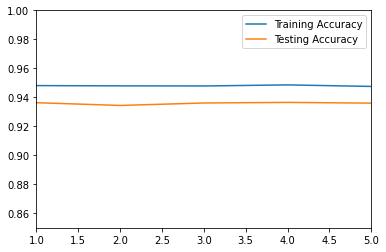

In [22]:
x = [1, 2, 3, 4, 5]
plt.plot(x, training_accuracy, label = "Training Accuracy")
plt.plot(x, testing_accuracy, label = "Testing Accuracy")
plt.xlim([1, 5])
plt.ylim([0.85, 1.00])
plt.legend()
plt.show()